Collaborative filtering with Keras
- inspiration - https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [0]:
import pandas as pd
import random
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Seed for reproducibility

In [0]:
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

Read Data + perform some preprocessing steps

In [4]:
ratings_df = pd.read_parquet('/content/drive/My Drive/part.0.parquet')

# subset to records with a rating
  # unclear how to train with unrated items
ratings_df = ratings_df[ratings_df['rating'] > 0]

ratings_df = ratings_df.sample(n=100000)
print(ratings_df.shape)
ratings_df.head()

(100000, 5)


,user_id,book_id,is_read,rating,is_reviewed
index,,,,,
2870594,5685,570143,1,1,0
75879,174,7600,1,5,1
2456344,4886,634,1,3,0
453947,932,7476,1,3,0
2596614,5134,6510,1,4,0


Encode users and books as integer indices

In [5]:
# random shuffle
df = ratings_df.sample(frac=1)

# encode users and books
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
book_ids = df["book_id"].unique().tolist()
book2book_encoded = {x: i for i, x in enumerate(book_ids)}
df["user"] = df["user_id"].map(user2user_encoded)
df["book"] = df["book_id"].map(book2book_encoded)

df.head()

,user_id,book_id,is_read,rating,is_reviewed,user,book
index,,,,,,,
3711539,7315,41144,1,5,0,0,0
1505815,2991,14907,1,5,0,1,1
136070,311,74094,1,3,0,2,2
317503,659,135673,1,3,0,3,3
1628068,3215,48272,1,5,0,4,4


In [0]:
x = df[["user", "book"]].values

# Normalize the book ratings between 0 and 1.
min_rating = min(df["rating"])
max_rating = max(df["rating"])
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [0]:
EMBEDDING_SIZE = 50
num_users = len(set(ratings_df['user_id']))
num_books = len(set(ratings_df['book_id']))

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
    ,metrics=[tf.keras.metrics.RootMeanSquaredError(name='RMSE')]
)

In [8]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1407/1407 [==============================] - 30s 21ms/step - loss: 0.6678 - RMSE: 0.3129 - val_loss: 0.6123 - val_RMSE: 0.2655
Epoch 2/5
1407/1407 [==============================] - 30s 21ms/step - loss: 0.5869 - RMSE: 0.2414 - val_loss: 0.6425 - val_RMSE: 0.2914
Epoch 3/5
1407/1407 [==============================] - 30s 21ms/step - loss: 0.5737 - RMSE: 0.2311 - val_loss: 0.6322 - val_RMSE: 0.2822
Epoch 4/5
1407/1407 [==============================] - 29s 21ms/step - loss: 0.5707 - RMSE: 0.2278 - val_loss: 0.6356 - val_RMSE: 0.2844
Epoch 5/5
1407/1407 [==============================] - 30s 21ms/step - loss: 0.5761 - RMSE: 0.2315 - val_loss: 0.6347 - val_RMSE: 0.2828


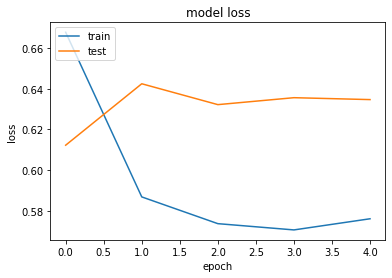

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


Model required us to normalize the rating values. How to interpret the RMSE of normalized rating values?

For now, de denormalize predictions and actual values and then calculate RMSE

In [10]:
predictions = model.predict(x_val)

# de normalize values
real_vals = (y_val*(max_rating - min_rating)) + min_rating

predictions = predictions.reshape(len(x_val),)
real_predictions = (predictions*(max_rating - min_rating)) + min_rating

# RMSE
np.sqrt(np.mean(real_vals - real_predictions))

0.8443889696884257

Train/val loss graphs show overfitting

However interesting that only 5 epochs beats the RMSEs of default Surprise algorithms.

